# ETL Pipeline example: OracleDB
* Extract: Read Parquet files from a datalake like AWS S3 
* Transform: Transform: Transform the raw data to something consumable by users, analytics team, business intelligence, dashboards, etc 
* Load: Load data to Oracle database

### Notes on running these queries:

By default, the code in this Notebook uses Bodo, which automatically distributes data chunks across cores.

The output cells were generated by executing the code on two **c5.2xlarge** instance 2 x (8 cores, 32GiB memory) using the Parquet version of [this](https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/metro/totals/cbsa-est2017-alldata.csv) dataset, which we generated and uploaded to a public S3 bucket.


To run the code:
1. You need to add your AWS account and database credentials to access the data. You can store your credentials in a file called credentials.json similar to the one shown below. We recently made the input parquet files publicly available. Therefore, no need for AWS credentials, but you still need your database credentials. 


```json
# content of credentials.json file
{
    "aws": {
        "aws_access_key_id": "xxxxxx",
        "aws_secret_access_key": "xxxxxx"
    },

    "Oracle":{
        "user": "xxx",
        "pass": "xxx",
        "server_url": "xxxx",
        "database_name": "xxxx",
    }
}
```

2. If you want to run a query in regular pandas:
    1. Comment out the lines with Jupyter parallel magic (`%autopx`) and the Bodo decorator (`@bodo.jit`) from the code cells.
    2. Then, re-run cells from the beginning.

The code cell below checks if you are running this example on the Bodo platform or locally on your machine. If you are running locally, it will create a single node cluster with a maximum of 8 cores.


In [1]:
import os
if os.environ.get("BODO_PLATFORM_WORKSPACE_UUID",'NA') == 'NA':
    print("You are not on Bodo Platform, running ipyparallel.. ")
    import ipyparallel as ipp
    import psutil; n = min(psutil.cpu_count(logical=False), 8)
    rc = ipp.Cluster(engines='mpi', n=n).start_and_connect_sync(activate=True)

In [2]:
%autopx
import bodo
print(f"Hello World from rank {bodo.get_rank()}. Total ranks={bodo.get_size()}")

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

%autopx enabled
Hello World from rank 0. Total ranks=1


## Extract

The first step in an ETL pipeline is to read some raw data. 

In this example we are going to read it from a bucket in AWS S3. 


In [3]:
import os
import json
import time
import bodo
import datetime
import cx_Oracle
import numpy as np
import pandas as pd

path_to_conn_creds = "credentials.json"
with open(path_to_conn_creds) as f:
    creds = json.load(f)

# The S3 bucket for this data is public. But just in case, you can set aws credentials as follow: 
# os.environ["AWS_ACCESS_KEY_ID"] = creds["aws"]["aws_access_key_id"]
# os.environ["AWS_SECRET_ACCESS_KEY"] = creds["aws"]["aws_secret_access_key"]
# os.environ["AWS_DEFAULT_REGION"] = "us-east-2"


conn_format = "oracle+cx_oracle://{username}:{password}@{host}/{db_name}"
conn = conn_format.format(username=creds["Oracle"]["user"], 
                          password=creds["Oracle"]["pass"], 
                          host=creds["Oracle"]["server_url"], 
                          db_name=creds["Oracle"]["database_name"])


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

Let's read the data from S3:

In [4]:
@bodo.jit()
def read_parquet(s3_path):
    df = pd.read_parquet(s3_path)
    print(df.shape)
    return df

# this is a +200MB parquet file
s3_path = 's3://bodo-example-data/census/census-population-2010-2017.pq'
# s3_path = 's3://bodo-example-data/census/census-population-2010-2017_2x.pq'
population = read_parquet(s3_path)




%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stderr:0] /opt/conda/lib/python3.9/site-packages/bodo/io/parquet_pio.py:881: BodoWarning: Total number of row groups in parquet dataset s3://bodo-example-data/census/census-population-2010-2017.pq (1) is too small for effective IO parallelization.
For best performance the number of row groups should be greater than the number of workers (8). For more details, refer to
https://docs.bodo.ai/latest/file_io/#parquet-section.

  warnings.warn(BodoWarning(


[stdout:0] (2789, 79)


In [5]:
if bodo.get_rank() ==  0:
    display(population.head())

[output:0]

,CBSA,MDIV,STCOU,NAME,LSAD,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,NETMIG2016,NETMIG2017,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017
0,10180,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,165252,165248,165583,166633,167452,...,-402,-167,-4,-14,-8,20,-17,-18,-2,-5
1,10180,NaN,48059.0,"Callahan County, TX",County or equivalent,13544,13544,13511,13508,13483,...,239,192,-1,-1,-2,-2,-1,-1,-1,1
2,10180,NaN,48253.0,"Jones County, TX",County or equivalent,20202,20193,20237,20267,19874,...,37,-8,2,4,10,4,2,1,0,1
3,10180,NaN,48441.0,"Taylor County, TX",County or equivalent,131506,131511,131835,132858,134095,...,-678,-351,-5,-17,-16,18,-18,-18,-1,-7
4,10420,NaN,NaN,"Akron, OH",Metropolitan Statistical Area,703200,703203,703037,703152,702066,...,-1187,770,-34,-49,-36,-73,-103,-56,-4,-25


## Transform

After extracting data, it is time to transform it. 

Let's first define some utility functions that come in handy later. 

They help with [type stability](https://docs.bodo.ai/2022.6/dev_guide/?h=get_keys#bodo-jit-requirements) when calling the column names under a given condition.

In [6]:
@bodo.jit(distributed=False)
def get_keys(df_columns, start_with):
    keys = [c for c in df_columns if c.startswith(start_with)]
    return keys

In [7]:
@bodo.jit(distributed=False)
def column_reorder(df_columns):
    """ brings the last column to the first column"""
    cols = list(df_columns)
    cols = cols[-1:] + cols[:-1]
    return cols

We will use these functions as utility functions for the the `transformation()` function, which performs the actual data transformation. This function also uses two helper functions to carry out this task, `cleanup_population()` and `population_long()`. The former cleans the data and the latter convert its table format from wide to long using  `pandas.DataFrame.melt()`. 

In [8]:
@bodo.jit(distributed=['population', 'pop_by_state', 'max_pop_state'])
def cleanup_population(population):
    """ Transform data from raw to consumable"""

    # keep the relevant columns only i.e. the columns that contain year-population-estimate and index names
    pop_idx = ["CBSA", "MDIV", "STCOU", "NAME", "LSAD"]
    population[["CITY", "STATE"]] = population["NAME"].apply(lambda row: pd.Series([row.split(",")[0], row.split(",")[1]], index=["City", "State"] ))


    # Aggregations: Find the total populations per state and LSAD (i.e., Metro or County)   
    pop_cols = get_keys(population.columns, "POPEST")
    pop_by_state = population.groupby(["STATE", "LSAD"], as_index=False)[pop_cols].agg("sum")


    # Find Cities with max population within each state, a groupby followed by a merge
    max_pop_state = population.groupby(["STATE"], as_index=False)[pop_cols].agg("max")
    max_pop_state = pd.merge(
        max_pop_state, population[pop_cols + ["STATE", "NAME"]], on=pop_cols + ["STATE"]
    )
    
    max_pop_state.sort_values(by=["STATE"], inplace=True)
    # Drop the redundant State column
    max_pop_state = max_pop_state.drop(["STATE"], axis=1)

    # Column Reording:
    cols = column_reorder(max_pop_state.columns)
    max_pop_state = max_pop_state[cols]
    max_pop_state['ETL_timestamp'] = datetime.datetime.now()
    
    print(pop_by_state.shape)
    print(max_pop_state.shape)
    
    return population, pop_by_state, max_pop_state, pop_cols, pop_idx

# df = cleanup_population(population)
population, pop_by_state, max_pop_state, pop_cols, pop_idx = cleanup_population(population)


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0] (221, 10)
(109, 10)


In [9]:
if bodo.get_rank() == 0:
    display(population.sample(5))
    display(max_pop_state.sample(5))
    display(pop_by_state.sample(5))


[output:0]

,CBSA,MDIV,STCOU,NAME,LSAD,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,CITY,STATE
274,16740,NaN,45023.0,"Chester County, SC",County or equivalent,33140,33140,33146,32862,32686,...,-2,0,4,-5,1,-5,-1,-1,Chester County,SC
293,16980,NaN,NaN,"Chicago-Naperville-Elgin, IL-IN-WI",Metropolitan Statistical Area,9461105,9461541,9471312,9497177,9525765,...,-226,160,-195,-228,77,269,88,165,Chicago-Naperville-Elgin,IL-IN-WI
239,16020,NaN,29017.0,"Bollinger County, MO",County or equivalent,12363,12363,12347,12380,12447,...,1,-1,0,-1,0,0,0,-1,Bollinger County,MO
229,15540,NaN,50013.0,"Grand Isle County, VT",County or equivalent,6970,6970,6948,6969,6967,...,-1,-1,-1,-2,1,-1,1,0,Grand Isle County,VT
145,13220,NaN,NaN,"Beckley, WV",Metropolitan Statistical Area,124898,124913,124959,125183,125014,...,-9,-8,-17,-6,0,-2,-1,2,Beckley,WV


[output:0]

,NAME,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,ETL_timestamp
69,"New Castle County, DE",538831,542282,546120,549486,552465,555587,557851,559793,2022-07-11 18:53:05.619450
91,"Washington-Arlington-Alexandria, DC-VA-MD-WV",5665818,5776337,5872227,5962606,6029537,6091560,6150681,6216589,2022-07-11 18:53:05.619450
52,"Miami-Fort Lauderdale-West Palm Beach, FL",5583888,5696288,5780894,5862992,5943656,6026044,6107433,6158824,2022-07-11 18:53:05.619450
33,"Fort Smith, AR-OK",280686,281216,281027,280156,279858,280393,281032,282086,2022-07-11 18:53:05.619450
32,"Fayetteville-Springdale-Rogers, AR-MO",465290,475098,484093,492739,502187,513262,525176,537463,2022-07-11 18:53:05.619450


[output:0]

,STATE,LSAD,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017
19,HI,County or equivalent,1363817,1378323,1392772,1408038,1417710,1426320,1428683,1427538
9,MT,County or equivalent,639861,644986,649752,656743,663971,671391,681139,691669
28,IA-IL-MO,Micropolitan Statistical Area,62074,61575,61323,60669,60260,59913,59406,59038
26,TN,Micropolitan Statistical Area,823167,825230,826602,828411,832443,835149,839895,846999
2,IA,County or equivalent,2303350,2320345,2334569,2353384,2371772,2388610,2403915,2420869


In [10]:
@bodo.jit(distributed=['population', 'population_melt'])
def population_long(population, pop_cols, pop_idx):
    population_melt = population.melt(
        id_vars=pop_idx,
        value_vars=pop_cols,
        var_name="YEAR",
        value_name="POPULATION_EST",
    )
    population_melt["YEAR"] = population_melt["YEAR"].apply(lambda x: x[-4:])  # e.g. POPESTIMATE2010 -> 2010
    population_melt.sort_values(by=["YEAR", "POPULATION_EST"], inplace=True, ascending=[True, False])
    # population_melt['ETL_timestamp'] = datetime.datetime.now()
    print(population_melt.shape)
    return population_melt


population_melt = population_long(population, pop_cols, pop_idx)
if bodo.get_rank() == 0:
    display(population_melt.sample(5))


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0] (22312, 7)


[output:0]

,CBSA,MDIV,STCOU,NAME,LSAD,YEAR,POPULATION_EST
11356,10140,NaN,53027.0,"Grays Harbor County, WA",County or equivalent,2010,72851
14157,21980,NaN,NaN,"Fallon, NV",Micropolitan Statistical Area,2010,24822
145,13220,NaN,NaN,"Beckley, WV",Metropolitan Statistical Area,2010,124959
19851,48780,NaN,38105.0,"Williams County, ND",County or equivalent,2010,22586
18,10580,NaN,36091.0,"Saratoga County, NY",County or equivalent,2010,220109


## Load

The last part of an ETL job is to load the processed data to a data warehouse. It could be a data lake like ASW S3, or a database like Snowflake.

In this example, we load the processed data to Oracledb.

In [13]:
# from sqlalchemy import types

@bodo.jit(distributed=['df'])
def write_oracle(df, table_name, conn, mode):
    df.to_sql(table_name, conn, index=False, if_exists=mode)

write_oracle(population_melt, "population", conn, "replace")
write_oracle(max_pop_state, "max_pop_per_state", conn, "replace")
write_oracle(pop_by_state, "pop_by_state", conn, "replace")

[stderr:0] /opt/conda/lib/python3.9/site-packages/bodo/hiframes/pd_dataframe_ext.py:2784: BodoWarning: DataFrame.to_sql(): schema argument is recommended to avoid permission issues when writing the table.
  warnings.warn(BodoWarning(
/opt/conda/lib/python3.9/site-packages/bodo/hiframes/pd_dataframe_ext.py:2784: BodoWarning: DataFrame.to_sql(): schema argument is recommended to avoid permission issues when writing the table.
  warnings.warn(BodoWarning(
/opt/conda/lib/python3.9/site-packages/bodo/hiframes/pd_dataframe_ext.py:2784: BodoWarning: DataFrame.to_sql(): schema argument is recommended to avoid permission issues when writing the table.
  warnings.warn(BodoWarning(
/opt/conda/lib/python3.9/site-packages/bodo/hiframes/pd_dataframe_ext.py:2784: BodoWarning: DataFrame.to_sql(): schema argument is recommended to avoid permission issues when writing the table.
  warnings.warn(BodoWarning(
/opt/conda/lib/python3.9/site-packages/bodo/hiframes/pd_dataframe_ext.py:2784: BodoWarning: DataF

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

## Data Analysis

Let's look at a few areas to see if the population is growing or shrinking. To get this insight, we need to pull data from the database and analyze or visualize it.


We first need to connect to the database, define the query, and then we will use the `pandas.read_sql()` function to read the data. Since we already created the engine to connect, we don't need to do it again.


In [14]:
sql1 = "SELECT DISTINCT NAME, YEAR, POPULATION_EST FROM population WHERE STCOU is NULL"

@bodo.jit(distributed=["df"])
def read_oracle(sql, conn):
    df = pd.read_sql(sql, conn)
    return df

df1 = read_oracle(sql1, conn)
if bodo.get_rank() == 0:
    display(df1.head())

[output:0]

,name,year,population_est
0,"Harrisburg-Carlisle, PA",2010,550108
1,"Flint, MI",2010,424938
2,"Fayetteville, NC",2010,374710
3,"Tallahassee, FL",2010,369339
4,"Tuscaloosa, AL",2010,230487


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:1]

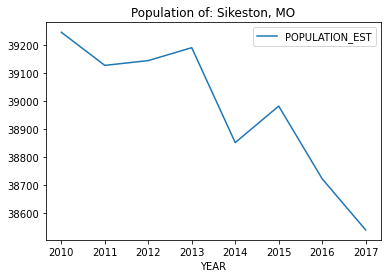

[output:1]

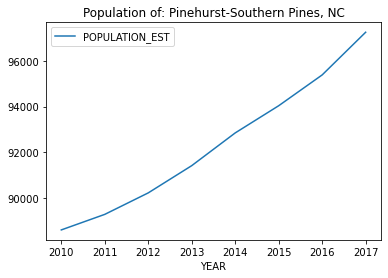

[output:1]

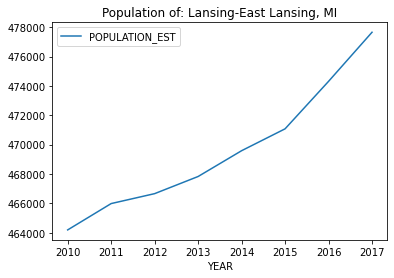

In [15]:
# %matplotlib inline
from random import choice

@bodo.jit(distributed=['df'])
def gather_data(df):
    return bodo.gatherv(df, root=1)

df = gather_data(df1)
if bodo.get_rank()==1:
    df.columns = df.columns.str.upper()
    metro_names = list(df['NAME'])
    sample_metro_names = [choice(metro_names) for _ in range(3)]
    df.sort_values(by='YEAR', inplace=True)                      
    for metro in sample_metro_names:
        df[df['NAME'] == metro].set_index('YEAR').plot(title=f'Population of: {metro}')

